In [41]:
import matplotlib.pyplot as plt
import numpy as np
import tempfile
import tensorflow as tf
import xarray as xr
import yaml
from os.path import join
from toolz.itertoolz import groupby

from fv3fit.train_microphysics import TrainConfig

In [23]:
plt.style.use("seaborn-colorblind")

In [5]:
# load sizeable chunk of training data
# load models for gscond and precpd w/ dense counterpart
# do a basic skill calculation by column
# plot a vertical plot of skill w/ everything on it and matching colors

In [24]:
base_path = "gs://vcm-ml-experiments/microphysics-emulation/2022-12-11"
model_names = {
    "precpd-rnn": "precpd-diff-only-no-pr-v1",
    "precpd-dense": "precpd-diff-only-dense-no-pr-v1",
    "gscond-dense-local": "gscond-only-qvout-v1",
    "gscond-dense": "gscond-only-dense-qvout-v1",
}

model_checkpoint = {
    "precpd-rnn": "checkpoints/epoch.014.tf",
    "precpd-dense": "checkpoints/epoch.047.tf",
    "gscond-dense-local": "checkpoints/epoch.047.tf",
    "gscond-dense": "checkpoints/epoch.047.tf",
}


In [14]:
# Use after successful run
# with tempfile.TemporaryDirectory() as tmpdir:
#     dst = f"{tmpdir}/config.yaml"
#     !gsutil cp {base_path}/{model_names["gscond-dense-local"]}/config.yaml {dst}
#     cfg = TrainConfig.from_yaml_path(dst)

In [25]:
gscond_cfg_path = "/home/andrep/repos/fv3net/projects/microphysics/train/gscond-only.yaml"
precpd_cfg_path = "/home/andrep/repos/fv3net/projects/microphysics/train/rnn-precpd-diff-only.yaml"

def _open_config(path):
    with open(path, "r") as f:
        cfg_dict = yaml.safe_load(f)["config"]
        return TrainConfig.from_dict(cfg_dict)

gscond_cfg = _open_config(gscond_cfg_path)
precpd_cfg = _open_config(precpd_cfg_path)

In [26]:
load_variables = gscond_cfg.model_variables | precpd_cfg.model_variables

In [27]:
test_ds = gscond_cfg.open_dataset(gscond_cfg.test_url, 100, list(load_variables))
profiles = next(iter(test_ds.unbatch().shuffle(200_000).batch(150_000)))

In [28]:
def get_targets(config, sample):
    transform = config.build_transform(sample)
    return transform.backward(transform.forward(sample))


targets = {}
for config in [gscond_cfg, precpd_cfg]:
    targets.update(get_targets(config, profiles))

In [29]:
targets.keys()

dict_keys(['air_temperature_after_gscond', 'specific_humidity_after_precpd', 'cloud_water_mixing_ratio_input', 'cloud_water_mixing_ratio_after_precpd', 'surface_air_pressure_after_last_gscond', 'specific_humidity_after_last_gscond', 'air_temperature_after_precpd', 'surface_air_pressure', 'air_temperature_after_last_gscond', 'specific_humidity_after_gscond', 'pressure_thickness_of_atmospheric_layer', 'cloud_water_mixing_ratio_after_gscond', 'air_temperature_input', 'specific_humidity_input', 'air_pressure', 'log_cloud_input', 'log_humidity_input', 'log_humidity_after_last_gscond', 'humidity_gscond_difference', 'humidity_gscond_difference_tscaled', 'relative_humidity', 'cloud_precpd_difference', 'temperature_precpd_difference', 'humidity_precpd_difference'])

In [30]:
models = {
    key: tf.keras.models.load_model(join(base_path, name, model_checkpoint[key]))
    for key, name in model_names.items()
}

/home/andrep/miniconda3/envs/fv3net/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['specific_humidity_after_gscond', 'cloud_water_mixing_ratio_after_gscond', 'air_temperature_after_gscond'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


/home/andrep/miniconda3/envs/fv3net/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['specific_humidity_after_gscond', 'air_temperature_after_gscond', 'cloud_water_mixing_ratio_after_gscond'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [31]:
def calc_skill(targets, predictions, keys):
    skill_out = {}
    for key in keys:
        diff = predictions[key] - targets[key]
        rmse = np.sqrt(np.mean(diff**2, axis=0))
        rms = np.sqrt(np.mean(targets[key]**2, axis=0))
        skill_out[key] = 1 - rmse/rms

    return skill_out

In [32]:
r2_columns = {}

gscond_fields = ["humidity_gscond_difference"]
precpd_fields = ['cloud_precpd_difference', 'temperature_precpd_difference', 'humidity_precpd_difference']

for key, model in models.items():
    result = model.predict(profiles, batch_size=8192)
    if "gscond" in key:
        use_fields = gscond_fields
    else:
        use_fields = precpd_fields

    skill = calc_skill(targets, result, use_fields)
    for field_key, r2_profile in skill.items():
        r2_columns[(key, field_key)] = r2_profile    


/home/andrep/miniconda3/envs/fv3net/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['specific_humidity_after_precpd', 'cloud_water_mixing_ratio_after_precpd', 'air_temperature_after_precpd'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/tmp/ipykernel_8987/3194010322.py:7: RuntimeWarning: divide by zero encountered in true_divide
  skill_out[key] = 1 - rmse/rms
/tmp/ipykernel_8987/3194010322.py:7: RuntimeWarning: invalid value encountered in true_divide
  skill_out[key] = 1 - rmse/rms
/home/andrep/miniconda3/envs/fv3net/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['air_temperature_after_gscond', 'specific_humidity_after_precpd', 'cloud_water_mixing_ratio_after_precpd', 'air_temperature_after_precpd', 'specific_humidity_after_gscond', 'cloud_water_mixing_ratio_after_gscond'] which did not match any model

In [36]:
var_key

'humidity_gscond_difference'

<Figure size 720x480 with 0 Axes>

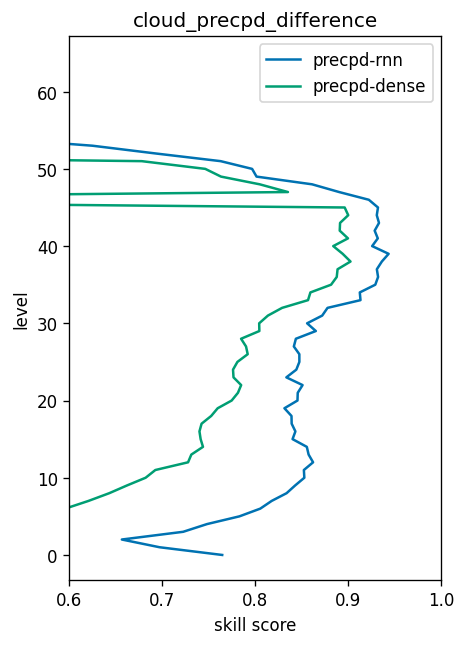

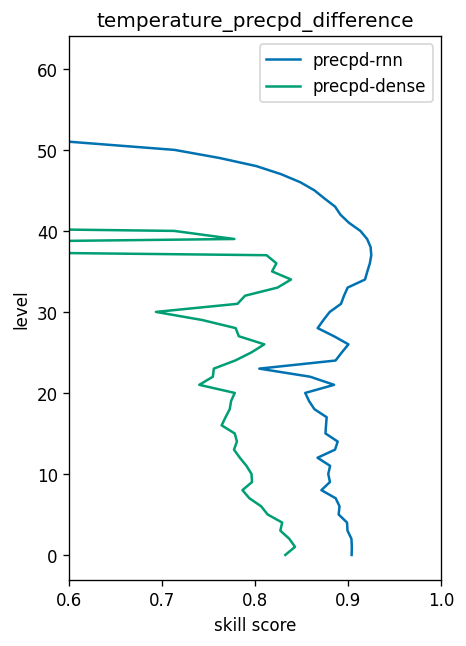

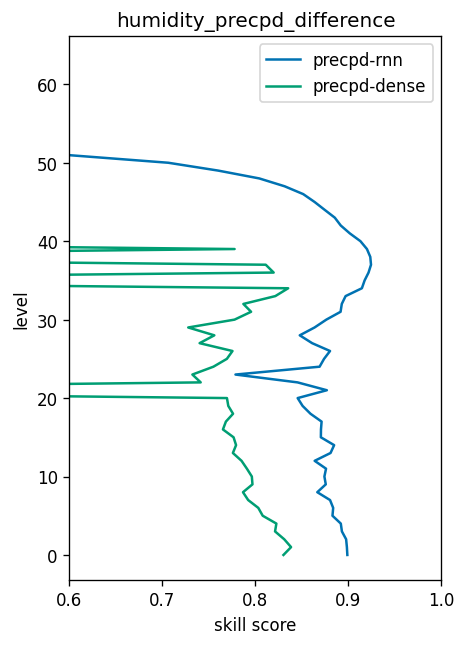

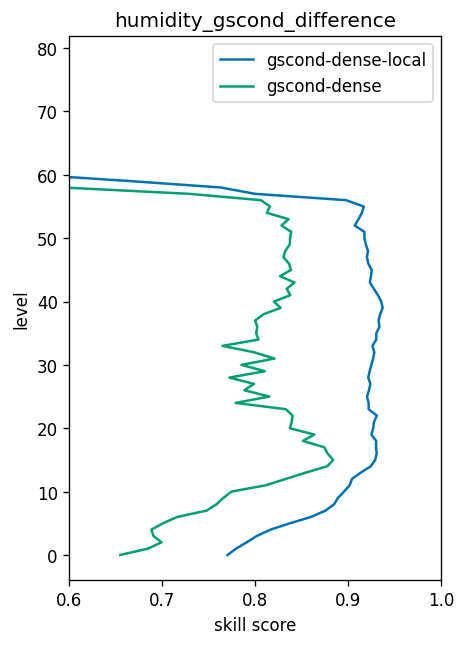

In [45]:
plt.figure(dpi=120)
for var_key, group in groupby(lambda x: x[1], r2_columns.keys()).items():

    plt.figure(dpi=120, figsize=(4,6))
    for key in group:
        data = xr.DataArray(r2_columns[key], dims=["z"])
        line, = data.plot(y="z", label=key[0])

    plt.xlabel("skill score")
    plt.ylabel("level")
    plt.title(var_key)
    plt.xlim(0.6, 1)
    plt.legend()
    plt.show()


This is probably just better as a table.  Train the models and re-run the scoring.

Also better to use the skill created in offline runs

Model Subroutine | Variable | dense | prior informed


Another table then is online skill scores